In [62]:
%matplotlib inline

In [63]:
#-----------------------------------------------------------
import math
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from matplotlib import cm        # module palettes de couleurs
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
#-----------------------------------------------------------
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (18, 6)
#np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth = 220)
np.set_printoptions(precision=4)
#np.set_printoptions(precision=3,formatter={'float': '{:9.3f}'.format})
pd.set_option('precision', 5)
pd.set_option("display.max_columns",20)
pd.set_option('display.max_rows', 999)
#pd.set_option('max_colwidth', 6)

In [64]:
linestyles = [(0, ()), # solid 
              (0, (5, 10)),(0, (5, 5)),(0, (5, 1)), # dashed (loosely/normal/densely)
              (0, (3, 10, 1, 10)),(0, (3, 5, 1, 5)),(0, (3, 1, 1, 1)), # dotted  (loosely/normal/densely)
              (0, (3, 10, 1, 10, 1, 10)),(0, (3, 5, 1, 5, 1, 5)),(0, (3, 1, 1, 1, 1, 1)), # dashdotted(loosely/normal/densely)
              (0, (1, 10)),(0, (1, 5)),(0, (1, 1))]
couleurs = cm.Dark2.colors

# ACP sur des températures mensuelles en France

***

Nous vous proposons de travailler avec des données réelles qui sont des relevés de températures.
Il s'agit d'enregistrements de températures moyennes mensuelles pour 15 villes. 
Les données sont fournies dans le fichier `temperatures_enFrance.txt`.

Pour chaque ville (première colonne du fichier), on a 16 informations qui sont les variables que l'on considérera dans cet exercice.

* 12 moyennes mensuelles de température en $^oC$ (colonnes de 1 à 12 :  `TJanvier` $\dots$ `TDecembre`)
* Latitude et Longitude (colonnes 13 et 14)
* Moyenne annuelle de la température (colonne 15)
* Amplitude thermale : Différence entre les températures maximales et minimales (colonne 16)

Dans le tableau utilisé pour réaliser l'ACP, **on a gardé uniquement les 12 températures moyennes mensuelles pour l'ensemble des 15 villes**.

On travaillera donc avec une matrice de taille 15 $\times$ 12.

Les variables restantes pourront être considérées comme des variables supplémentaires.

## Chargement des données :

In [65]:
# chargement des donnees (avec pandas)
df = pd.read_csv('temperatures_enFrance.txt',sep=';',index_col=0)

# un numpy array des valeurs numeriques (pour la suite)
data = df._get_numeric_data().values
nomDesVilles = list(df.index)
nomDesVariables_ = list(df)
nomDesVariables_ = nomDesVariables_[:-1] # on ne considere que les variables quantitatives

# on met une partie des individus et des variables de cote
indice_individus = np.array(range(15))
indice_variables = np.array(range(12))

# broadcasting 
X = data[indice_individus[:,None],indice_variables] 

# List Comprehensions
nomDesVariables = [nomDesVariables_[i] for i in indice_variables]
nomDesIndividus = [nomDesVilles[i] for i in indice_individus]

#nombreDIndividus = np.size(X,axis=0)
#nombreDeVariables = np.size(X,axis=1)

### Variables supplémentaires

In [66]:
indice_variables_sup = np.setdiff1d(np.array(range(0,len(nomDesVariables_))),indice_variables)         
nomDesVariables_sup = [nomDesVariables_[i] for i in indice_variables_sup] #nomDesVariables_[indice_variables_sup]
#X_var_sup = data[indice_individus,indice_variables_sup] 
X_var_sup = data[indice_individus[:,None],indice_variables_sup]
# comme on considère les corrélations il n'est pas necessaire de centrer ou de réduire les variables suppémentaires

In [67]:
# nettoyage des donnees chargees
# (on ne garde que les informations associees a l'acp.)
del data, nomDesVilles, nomDesVariables_
%whos

Variable               Type           Data/Info
-----------------------------------------------
PCA                    ABCMeta        <class 'sklearn.decomposition.pca.PCA'>
X                      ndarray        15x12: 180 elems, type `float64`, 1440 bytes
X_var_sup              ndarray        15x3: 45 elems, type `float64`, 360 bytes
Xc                     ndarray        15x12: 180 elems, type `float64`, 1440 bytes
Xcr                    ndarray        15x12: 180 elems, type `float64`, 1440 bytes
ax                     AxesSubplot    AxesSubplot(0.125,0.125;0.775x0.755)
cm                     module         <module 'matplotlib.cm' f<...>ckages/matplotlib/cm.py'>
couleurs               tuple          n=8
df                     DataFrame                   TJanvier  TF<...>2  \nVichy         16.9  
donnees                DataFrame                   TJanvier_cr <...>chy            -0.73868  
ecartTypes             ndarray        12: 12 elems, type `float64`, 96 bytes
i                    

## Etude préliminaire et visualisation des données :

#### Moyenne pour chaque colonne/variable

In [87]:
moyennes = X.mean(axis=0)
moyennes

array([ 3.9733,  4.8333,  8.2333, 10.98  , 14.4333, 17.8333, 19.8333, 19.5667, 16.9867, 12.32  ,  7.9267,  4.8467])

#### Ecart-type pour chaque colonne/variable 
(Chaque colonne/variable est centrée.)

In [88]:
#ecartTypes = X.std(axis=0,ddof=0)
ecartTypes = X.std(axis=0,ddof=1)
ecartTypes

array([2.0073, 1.8684, 1.5291, 1.4148, 1.5046, 1.7935, 2.1289, 2.012 , 1.8481, 1.83  , 1.8038, 1.9584])

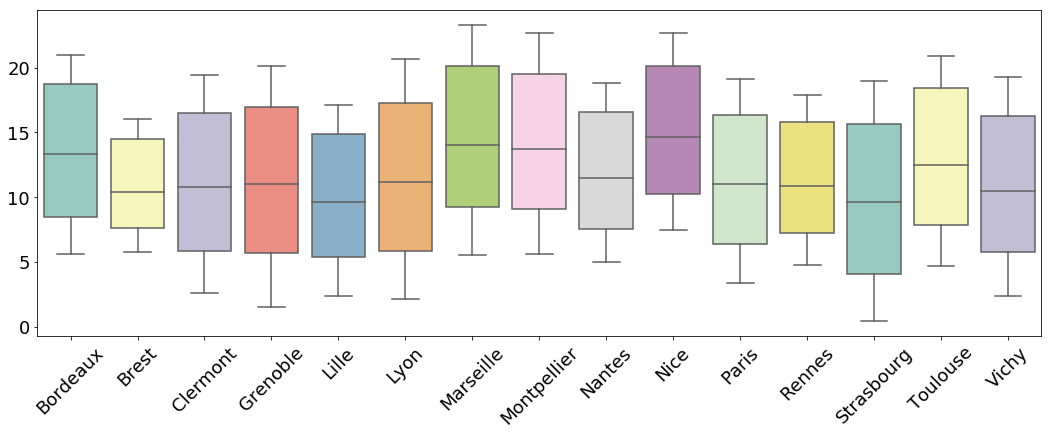

In [89]:
import seaborn as sns
ax = sns.boxplot(data=pd.DataFrame(data=X.T,columns=nomDesIndividus), palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

#### Données centrées et données centrées-réduites 
(Chaque colonne/variable est centrée et réduite.)

In [90]:
Xc = X - moyennes
Xcr = Xc / ecartTypes
#Xcr.std(axis=0,ddof=0)
#np.size(np.cov(Xcr.T,ddof=0),1)

#### Tableau des données (utilisées dans la suite)

In [91]:
donnees = pd.DataFrame(data=Xcr, index=nomDesIndividus, columns=nomDesVariables)
donnees.columns = [str(col) + '_cr' for col in donnees.columns]
donnees

,TJanvier_cr,TFevrier_cr,TMars_cr,TAvril_cr,TMai_cr,TJuin_cr,TJuillet_cr,TAout_cr,TSeptembre_cr,TOctobre_cr,TNovembre_cr,TDecembre_cr
Bordeaux,0.81038,0.94555,1.35157,1.28638,0.90833,0.81776,0.50103,0.71240,0.87296,0.80875,0.65050,0.69102
Brest,1.05947,0.51737,-0.28339,-1.25811,-1.88312,-1.91431,-1.98847,-1.77271,-1.23730,-0.17486,0.59506,1.09951
Clermont,-0.68417,-0.60658,-0.47959,-0.48063,-0.42093,-0.29737,-0.20354,-0.23194,-0.42566,-0.61203,-0.73550,-0.63656
Grenoble,-1.23217,-0.87418,-0.34879,-0.26859,0.04431,-0.01859,0.12526,-0.03313,-0.15511,-0.50274,-0.79094,-1.30035
Lille,-0.78381,-1.03475,-1.46057,-1.47015,-1.35141,-1.41250,-1.28389,-1.22598,-1.23730,-1.04919,-1.01270,-0.68762
Lyon,-0.93326,-0.82066,-0.34879,-0.05654,0.31016,0.37171,0.40709,0.26508,-0.04689,-0.50274,-0.68006,-0.89186
Marseille,0.76056,0.94555,1.15538,1.42774,1.57296,1.65412,1.62835,1.60703,1.57638,1.46449,1.26034,1.04845
Montpellier,0.81038,0.99907,1.08998,1.28638,1.17418,1.26382,1.34652,1.35852,1.25173,1.24591,1.14946,0.84421
Nantes,0.51147,0.24977,0.10900,-0.12722,-0.35447,-0.35313,-0.48537,-0.48045,-0.31744,-0.06557,0.15154,0.33360
Nice,1.75692,1.96245,1.67857,1.63979,1.50650,1.26382,1.34652,1.45793,1.79282,2.01094,1.98106,1.71224


### Visualisations des données
(Les individus correspondent aux villes. Chaque individu est affiché comme une courbe. On a donc, pour chaque courbe, douze points, un pour chaque variable.)

#### Les données originales (comme dans le fichier)

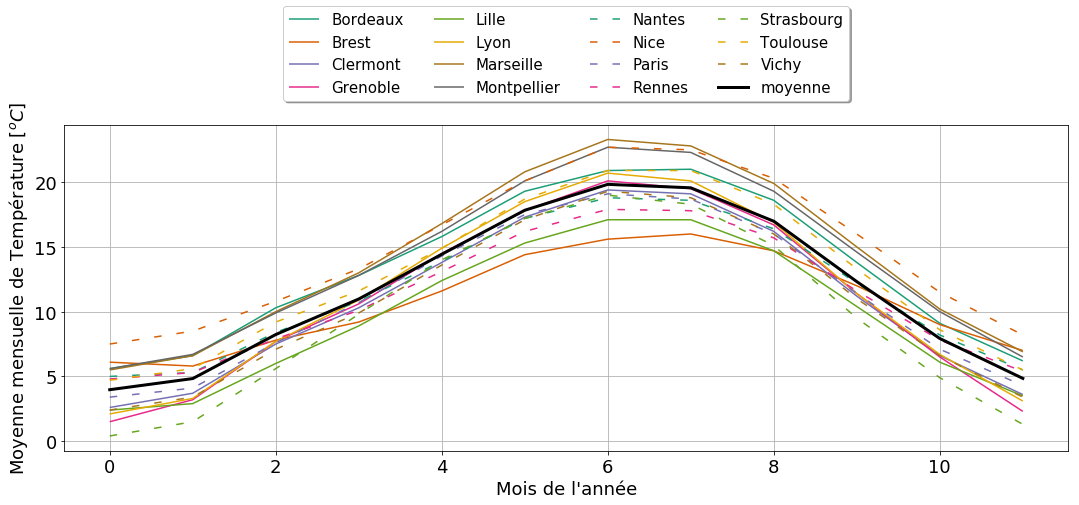

In [92]:
#la figure
for i, (ligne,label) in enumerate(zip(X, nomDesIndividus)):
    plt.plot(ligne, label=label,
             color = couleurs[i%len(couleurs)],
             linestyle=linestyles[(i//len(couleurs))%len(linestyles)])
plt.plot(moyennes,'k-',label="moyenne",linewidth=3)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=True, shadow=True,fontsize=15)
plt.grid(True)
plt.xlabel("Mois de l'année")
plt.ylabel("Moyenne mensuelle de Température [$^oC$]") ;

#### Les données centrées (par colonne/variable)

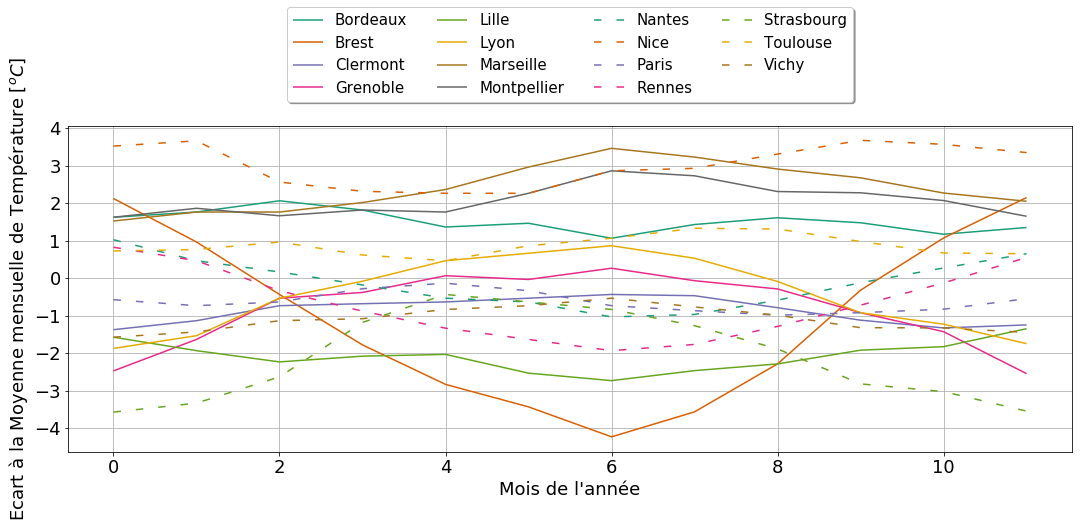

In [93]:
#la figure
for i, (ligne,label) in enumerate(zip(Xc, nomDesIndividus)):
    plt.plot(ligne, label=label,
             color = couleurs[i%len(couleurs)],
             linestyle=linestyles[(i//len(couleurs))%len(linestyles)])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=True, shadow=True,fontsize=15)
plt.grid(True)
plt.xlabel("Mois de l'année")
plt.ylabel("Ecart à la Moyenne mensuelle de Température [$^oC$]") ;

#### Les données centrées réduites (par colonne/variable)

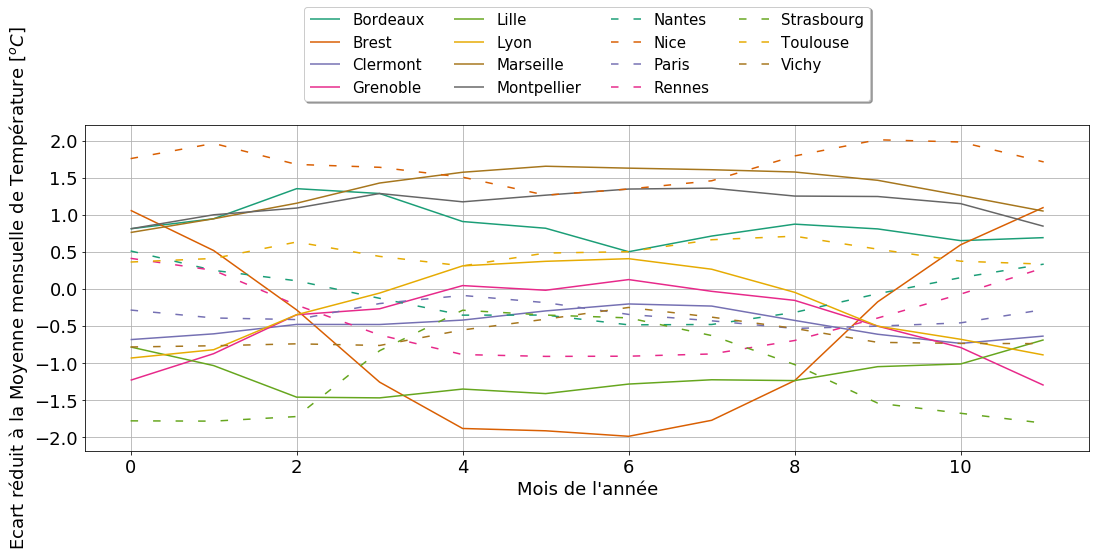

In [94]:
#la figure
for i, (ligne,label) in enumerate(zip(Xcr, nomDesIndividus)):
    plt.plot(ligne, label=label,
             color = couleurs[i%len(couleurs)],
             linestyle=linestyles[(i//len(couleurs))%len(linestyles)])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=True, shadow=True,fontsize=15)
plt.grid(True)
plt.xlabel("Mois de l'année")
plt.ylabel("Ecart réduit à la Moyenne mensuelle de Température [$^oC$]") ;

### Matrice de corrélations

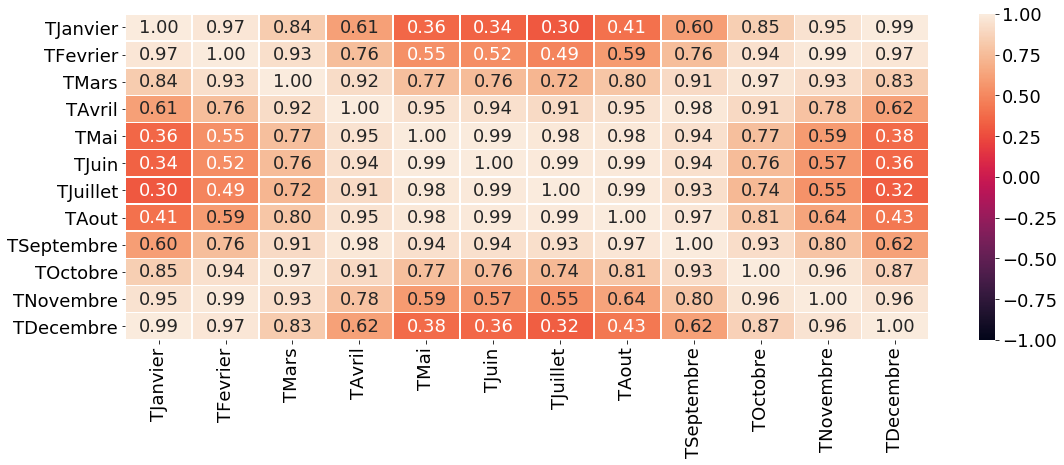

In [95]:
ax = sns.heatmap(df.iloc[indice_individus,indice_variables].corr(), annot=True, fmt=".2f", linewidths=.5, vmin=-1, vmax=1)

### Diagrammes de dispersion

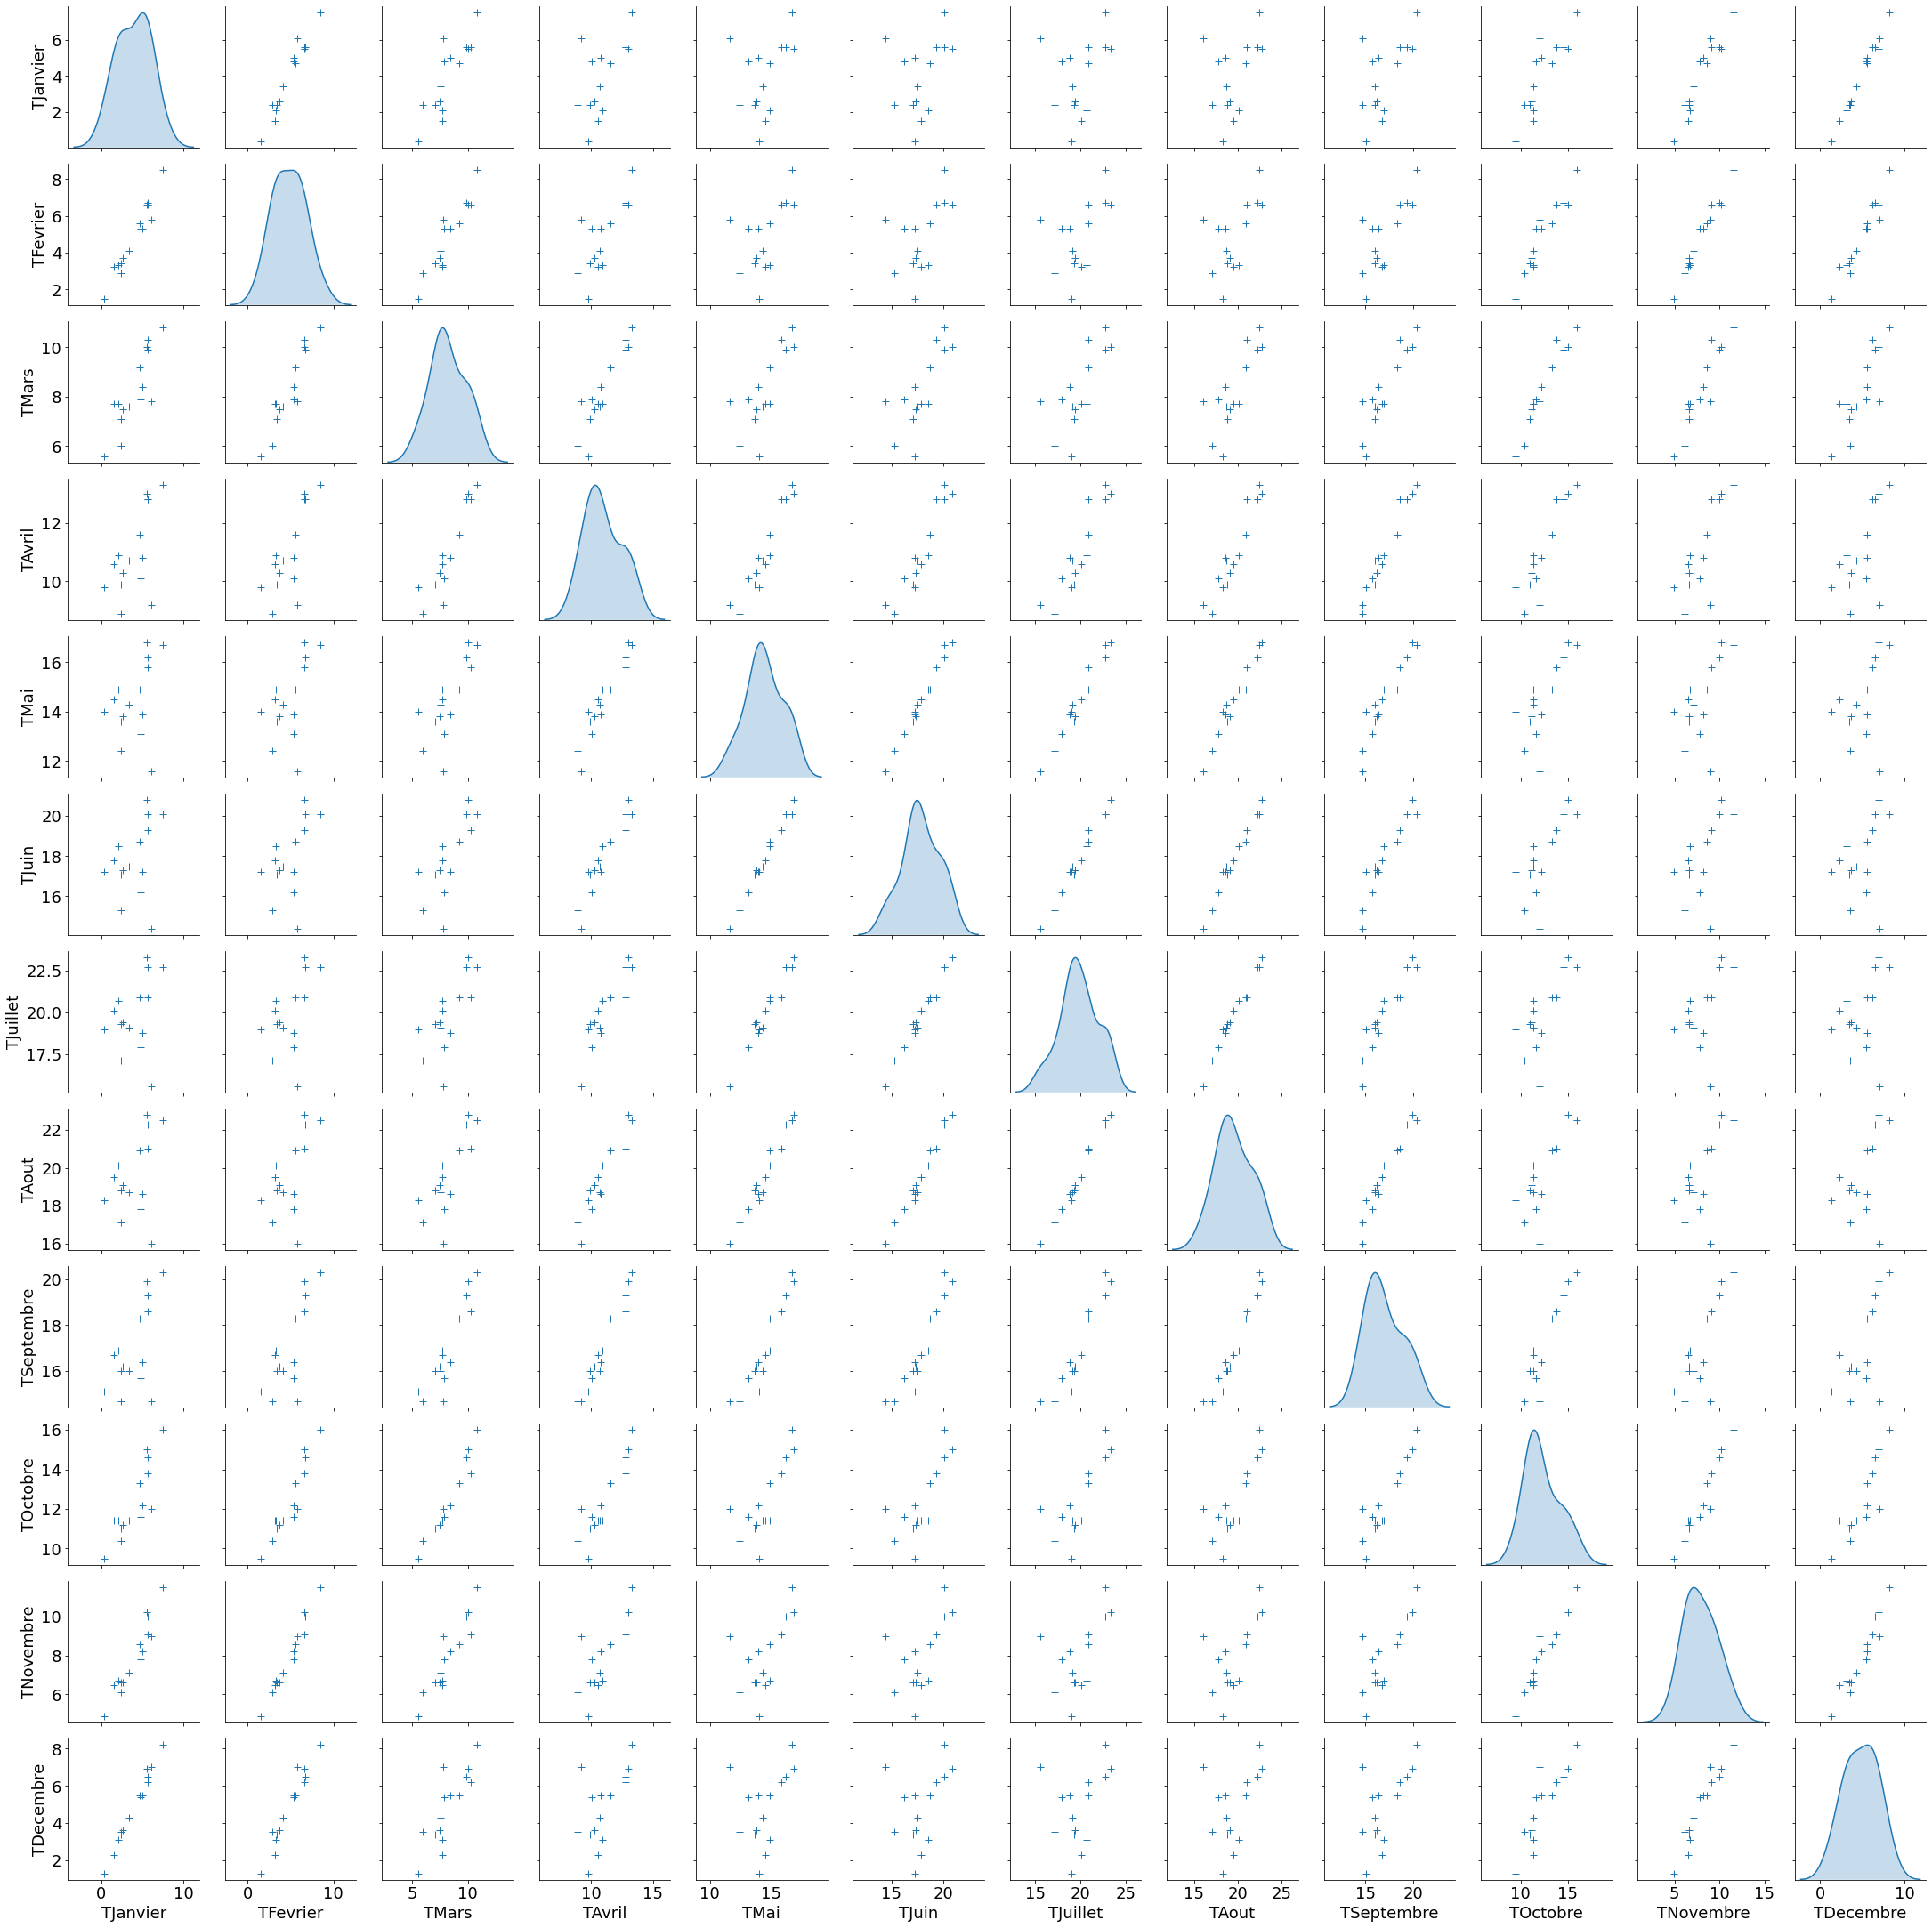

In [15]:
g = sns.pairplot(df.iloc[indice_individus,indice_variables], diag_kind="kde", markers="+",
                  plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                  diag_kws=dict(shade=True))

## Réalisation de l'ACP :

In [96]:
acp = PCA()
etude_centreeReduite = True
if etude_centreeReduite:
    CP = acp.fit(Xcr)
    lesNouvellesCoordonnees = acp.fit_transform(Xcr)
else:
    CP = acp.fit(X)
    lesNouvellesCoordonnees = acp.fit_transform(X)
# mise en forme
plesNouvellesCoordonnees = pd.DataFrame(data=lesNouvellesCoordonnees, index=nomDesIndividus, columns=list(range(1,acp.n_features_+1)))
plesNouvellesCoordonnees.columns = ['CP_' + str(col) for col in plesNouvellesCoordonnees.columns]
plesNouvellesCoordonnees

,CP_1,CP_2,CP_3,CP_4,CP_5,CP_6,CP_7,CP_8,CP_9,CP_10,CP_11,CP_12
Bordeaux,3.01489,0.10559,0.69639,0.01418,0.00757,0.00446,0.12079,0.01177,-0.02224,-0.01548,0.00071,-0.00435
Brest,-2.19110,3.95451,-0.11099,0.03922,0.09440,-0.14780,0.00814,0.02603,0.00217,-0.02307,0.00834,0.00058
Clermont,-1.66741,-0.57244,0.01846,0.16120,-0.14256,0.03027,-0.00166,-0.00150,-0.06531,0.00003,-0.00341,-0.00275
Grenoble,-1.47740,-1.63071,0.13283,0.38618,0.27345,-0.04480,-0.05152,-0.01155,-0.00722,0.00814,-0.01466,0.00224
Lille,-4.07384,0.57502,-0.34381,0.00477,0.03750,0.09418,0.16033,-0.00109,-0.02524,0.03116,0.00438,-0.00237
Lyon,-0.80663,-1.72759,0.02220,0.02187,-0.05364,-0.09329,-0.03213,-0.02457,0.02652,0.00238,0.04890,-0.00298
Marseille,4.66885,-0.80070,-0.34449,-0.14553,-0.04214,-0.14019,0.05993,-0.05174,-0.00713,-0.01375,-0.02335,-0.00156
Montpellier,4.00667,-0.42059,-0.17704,-0.02304,-0.04093,-0.02137,-0.08290,0.10847,-0.04578,0.01675,0.00327,0.00116
Nantes,-0.27175,1.07677,0.22045,-0.11504,-0.04354,-0.01757,-0.05509,0.01058,0.07280,0.04471,-0.01849,-0.00545
Nice,5.80335,0.76254,-0.19787,-0.06465,0.17934,0.16135,-0.03126,-0.03404,0.01311,-0.00117,0.01440,-0.00118


### Valeurs propres et vecteurs propres :

In [97]:
np.set_printoptions(precision=2)
print(" * valeurs propres des axes/facteurs (ordonnées) :\n",acp.singular_values_)
print(" * inerties des axes/facteurs (ordonnées) :\n",acp.singular_values_**2)
print(" * variance des axes/facteurs (ordonnées) :\n",acp.singular_values_**2/(np.size(X,axis=0)-1))
print(" * vecteurs propres :")
for i in range(len(acp.components_)):
    print("    v_{:<2d} :".format(i+1),acp.components_.T[:,i])
np.set_printoptions(precision=4)

 * valeurs propres des axes/facteurs (ordonnées) :
 [11.58  5.65  0.99  0.75  0.44  0.33  0.29  0.16  0.14  0.08  0.06  0.02]
 * inerties des axes/facteurs (ordonnées) :
 [1.34e+02 3.19e+01 9.80e-01 5.55e-01 1.97e-01 1.12e-01 8.47e-02 2.45e-02 2.09e-02 6.89e-03 4.00e-03 2.77e-04]
 * variance des axes/facteurs (ordonnées) :
 [9.58e+00 2.28e+00 7.00e-02 3.97e-02 1.40e-02 7.98e-03 6.05e-03 1.75e-03 1.49e-03 4.92e-04 2.86e-04 1.98e-05]
 * vecteurs propres :
    v_1  : [0.25 0.28 0.31 0.31 0.28 0.28 0.27 0.29 0.31 0.32 0.29 0.25]
    v_2  : [ 0.43  0.31  0.1  -0.13 -0.31 -0.33 -0.35 -0.28 -0.14  0.11  0.27  0.41]
    v_3  : [ 0.08  0.13  0.58  0.46  0.15  0.05 -0.31 -0.23 -0.16 -0.28 -0.32 -0.21]
    v_4  : [-0.26  0.06  0.55 -0.27 -0.46 -0.25  0.06  0.2   0.32  0.2  -0.02 -0.3 ]
    v_5  : [-0.27  0.05 -0.1   0.13  0.41 -0.3  -0.22 -0.33  0.07  0.4   0.41 -0.39]
    v_6  : [ 0.28  0.54 -0.37  0.04  0.09 -0.33  0.02  0.17  0.31 -0.05 -0.42 -0.26]
    v_7  : [-0.09 -0.38 -0.08  0.19  0.02 -0

### Variances et inerties des axes : 

#### Quelques considérations liant sklearn et le cours

In [98]:
#np.diag(np.cov(Xcr.T))
np.set_printoptions(precision=2)
print("variances :")
print(acp.explained_variance_," (facteurs)")
if etude_centreeReduite:
    print(np.diag(np.cov(Xcr.T,ddof=1))," (donnees)")
else:
    print(np.diag(np.cov(X.T,ddof=1))," (donnees)")

print("variance totale :")
print(" -",sum(acp.explained_variance_)," (facteurs)")
if etude_centreeReduite:
    print(" -",np.sum(np.diag(np.cov(Xcr.T,ddof=1)))," (donnees)")
else:
    print(" -",np.sum(np.diag(np.cov(X.T,ddof=1)))," (donnees)")
np.set_printoptions(precision=4)

variances :
[9.58e+00 2.28e+00 7.00e-02 3.97e-02 1.40e-02 7.98e-03 6.05e-03 1.75e-03 1.49e-03 4.92e-04 2.86e-04 1.98e-05]  (facteurs)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]  (donnees)
variance totale :
 - 11.999999999999993  (facteurs)
 - 12.0  (donnees)


#### Quelques considérations propre à sklearn

In [100]:
np.set_printoptions(precision=2)
print("inerties :")
print(acp.explained_variance_*(acp.n_samples_-1),"(methode 1)")
print(acp.singular_values_**2,"(methode 2)")
#
print("inertie totale :")
print(np.sum(acp.explained_variance_*(acp.n_samples_-1)),"(methode 1)")
print(np.sum(acp.singular_values_**2),"(methode 2)")
np.set_printoptions(precision=4)
#
with np.printoptions(formatter={'float': '{: 7.3f}'.format}):
    print("pourcentages d'inertie :\n",acp.explained_variance_ratio_*100)
    print("pourcentages d'inertie cumulées:\n",np.cumsum(acp.explained_variance_ratio_)*100)

inerties :
[1.34e+02 3.19e+01 9.80e-01 5.55e-01 1.97e-01 1.12e-01 8.47e-02 2.45e-02 2.09e-02 6.89e-03 4.00e-03 2.77e-04] (methode 1)
[1.34e+02 3.19e+01 9.80e-01 5.55e-01 1.97e-01 1.12e-01 8.47e-02 2.45e-02 2.09e-02 6.89e-03 4.00e-03 2.77e-04] (methode 2)
inertie totale :
167.99999999999991 (methode 1)
167.99999999999991 (methode 2)
pourcentages d'inertie :
 [ 79.848  18.970   0.583   0.331   0.117   0.067   0.050   0.015   0.012   0.004   0.002   0.000]
pourcentages d'inertie cumulées:
 [ 79.848  98.818  99.402  99.732  99.849  99.916  99.966  99.981  99.993  99.997  100.000  100.000]


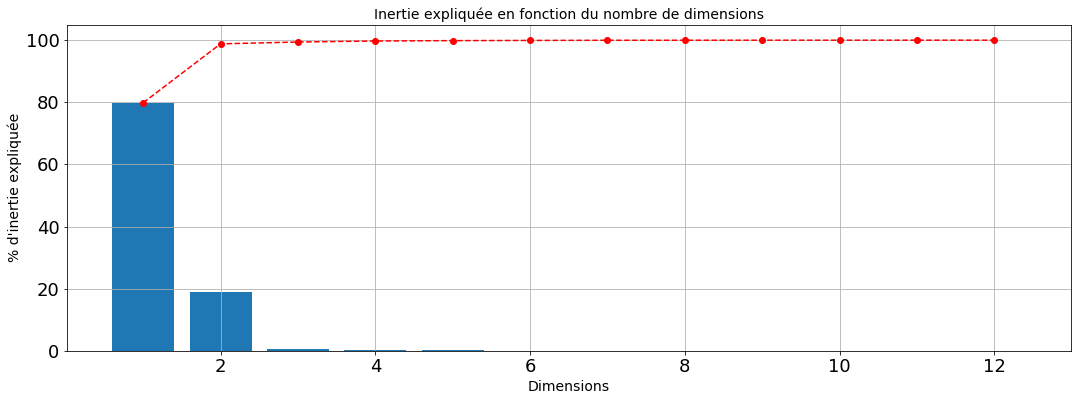

In [102]:
plt.bar(np.arange(len(acp.explained_variance_ratio_))+1,acp.explained_variance_ratio_*100)
plt.plot(np.arange(len(acp.explained_variance_ratio_))+1,np.cumsum(acp.explained_variance_ratio_*100),'r--o')
plt.xlabel("Dimensions",fontsize=14)
plt.ylabel("% d'inertie expliquée",fontsize=14)
plt.title("Inertie expliquée en fonction du nombre de dimensions",fontsize=14);
plt.grid(True)

#### Nombre de dimensions à conserver pour garder 95% de l'inertie ou au-delà :

In [103]:
# nombres de dimensions
pourcentageDInertieSeuil = 95
d = np.argmax(np.cumsum(acp.explained_variance_ratio_)>=pourcentageDInertieSeuil/100)+1
print("Nombres de dimensions (>={:.0f}% inertie) : ".format(pourcentageDInertieSeuil),d)
#pourcentageDInertieSeuil = 99
#d = np.argmax(np.cumsum(acp.explained_variance_ratio_)>=pourcentageDInertieSeuil/100)+1
#print("Nombres de dimensions (>={:.0f}% inertie) : ".format(pourcentageDInertieSeuil),d)

Nombres de dimensions (>=95% inertie) :  2


### Qualité de la représentation des individus (sur les nouveaux axes) en % :  
(ratio entre l'inertie de l'individu sur l'axe et l'inertie totale de l'individu)

In [104]:
qual = lesNouvellesCoordonnees*lesNouvellesCoordonnees
qual = (qual.T / qual.sum(axis=1)).T
qualite = pd.DataFrame(data=qual, index=nomDesIndividus, columns=list(range(1,acp.n_features_+1)))
del qual
#qualite.add_prefix('CP_')
qualite.columns = ['CP_' + str(col) for col in qualite.columns]
qualite*100

,CP_1,CP_2,CP_3,CP_4,CP_5,CP_6,CP_7,CP_8,CP_9,CP_10,CP_11,CP_12
Bordeaux,94.66877,0.11612,5.05094,0.00209,0.00060,0.00021,0.15197,1.44193e-03,0.00515,2.49611e-03,5.20297e-06,1.97301e-04
Brest,23.43625,76.33938,0.06013,0.00751,0.04350,0.10664,0.00032,3.30715e-03,0.00002,2.59841e-03,3.39567e-04,1.66597e-06
Clermont,87.98844,10.37051,0.01078,0.82234,0.64317,0.02901,0.00009,7.08761e-05,0.13498,2.12152e-08,3.68729e-04,2.39268e-04
Grenoble,42.89404,52.25810,0.34672,2.93077,1.46948,0.03945,0.05217,2.62176e-03,0.00102,1.30178e-03,4.22474e-03,9.84728e-05
Lille,97.15212,1.93557,0.69198,0.00013,0.00823,0.05192,0.15049,6.89806e-06,0.00373,5.68425e-03,1.12284e-04,3.28216e-05
Lyon,17.81371,81.71273,0.01349,0.01310,0.07877,0.23828,0.02827,1.65328e-02,0.01926,1.54672e-04,6.54655e-02,2.43157e-04
Marseille,96.41953,2.83586,0.52493,0.09368,0.00785,0.08694,0.01588,1.18409e-02,0.00023,8.36727e-04,2.41117e-03,1.07076e-05
Montpellier,98.57584,1.08622,0.19247,0.00326,0.01029,0.00280,0.04220,7.22490e-02,0.01287,1.72315e-03,6.56042e-05,8.32836e-06
Nantes,5.64533,88.63242,3.71506,1.01175,0.14492,0.02361,0.23204,8.55522e-03,0.40513,1.52782e-01,2.61279e-02,2.27374e-03
Nice,98.00514,1.69208,0.11393,0.01216,0.09360,0.07575,0.00284,3.37285e-03,0.00050,3.99729e-06,6.03603e-04,4.07070e-06


###### La vérification associée

In [23]:
qualite.sum(axis=1)

Bordeaux       1.0
Brest          1.0
Clermont       1.0
Grenoble       1.0
Lille          1.0
Lyon           1.0
Marseille      1.0
Montpellier    1.0
Nantes         1.0
Nice           1.0
Paris          1.0
Rennes         1.0
Strasbourg     1.0
Toulouse       1.0
Vichy          1.0
dtype: float64

### Contribution des individus (aux nouveaux axes) en % :  
(ratio entre l'inertie de l'individu sur l'axe et l'inertie totale de l'axe)

In [105]:
contr = lesNouvellesCoordonnees*lesNouvellesCoordonnees
contr = contr / contr.sum(axis=0)
contribution = pd.DataFrame(data=contr, index=nomDesIndividus, columns=list(range(1,acp.n_features_+1)))
del contr
contribution.columns = ['CP_' + str(col) for col in contribution.columns]
contribution*100

,CP_1,CP_2,CP_3,CP_4,CP_5,CP_6,CP_7,CP_8,CP_9,CP_10,CP_11,CP_12
Bordeaux,6.77592,0.03498,49.47583,0.03618,0.02917,0.01783,17.22922,0.56609,2.36802,3.47848e+00,0.01248,6.84707
Brest,3.57891,49.06879,1.25667,0.27697,4.53206,19.54891,0.07827,2.77011,0.02260,7.72563e+00,1.73827,0.12335
Clermont,2.07258,1.02821,0.03476,4.67809,10.33545,0.82023,0.00326,0.00916,20.41691,9.72966e-06,0.29115,2.73265
Grenoble,1.62714,8.34401,1.79995,26.84984,38.02825,1.79649,3.13457,0.54551,0.24947,9.61455e-01,5.37226,1.81116
Lille,12.37182,1.03749,12.05957,0.00409,0.71516,7.93713,30.35453,0.00482,3.05015,1.40935e+01,0.47932,2.02653
Lyon,0.48503,9.36488,0.05026,0.08614,1.46308,7.78869,1.21928,2.46914,3.36781,8.19963e-02,59.75318,3.21010
Marseille,16.24973,2.01168,12.10722,3.81296,0.90301,17.58925,4.24031,10.94574,0.24355,2.74554e+00,13.62194,0.87496
Montpellier,11.96724,0.55505,3.19773,0.09557,0.85189,0.40870,8.11548,48.10994,10.03232,4.07296e+00,0.26698,0.49023
Nantes,0.05505,3.63803,4.95797,2.38279,0.96410,0.27641,3.58408,0.45760,25.36879,2.90078e+01,8.54111,10.75061
Nice,25.10631,1.82453,3.99425,0.75242,16.35741,23.29718,1.15376,4.73927,0.82222,1.99372e-02,5.18341,0.50561


###### La vérification associée

In [106]:
contribution.sum(axis=0)

CP_1     1.0
CP_2     1.0
CP_3     1.0
CP_4     1.0
CP_5     1.0
CP_6     1.0
CP_7     1.0
CP_8     1.0
CP_9     1.0
CP_10    1.0
CP_11    1.0
CP_12    1.0
dtype: float64

### Corrélations entre anciennes et nouvelles variables
(Cela correspond à la projection des anciennes variables dans la nouvelle base.)

#### Détermination des coordonnées des variables sur les nouveaux axes :

In [107]:
corrOldNew = np.corrcoef(X.T,lesNouvellesCoordonnees.T)
corrOldNew = corrOldNew[0:len(nomDesVariables),len(nomDesVariables):]
coordonneesDesVariables = pd.DataFrame(data=corrOldNew,
                                       index=nomDesVariables,
                                       columns=list(range(1,acp.n_features_+1)))
del corrOldNew
coordonneesDesVariables.columns = ['CP_' + str(col) for col in coordonneesDesVariables.columns]
coordonneesDesVariables

,CP_1,CP_2,CP_3,CP_4,CP_5,CP_6,CP_7,CP_8,CP_9,CP_10,CP_11,CP_12
TJanvier,0.76124,0.64434,0.02142,-0.05099,-0.03147,0.02544,-0.00730,0.00705,0.02129,0.00952,0.00155,-0.00004
TFevrier,0.88046,0.46908,0.03356,0.01165,0.00534,0.04787,-0.02986,-0.00591,-0.01377,-0.00682,-0.00367,0.00124
TMars,0.96877,0.15601,0.15435,0.10922,-0.01244,-0.03304,-0.00614,-0.00960,0.00085,0.00275,0.00280,-0.00008
TAvril,0.96934,-0.20367,0.12174,-0.05407,0.01496,0.00348,0.01513,0.02435,-0.00960,-0.00212,-0.00162,-0.00156
TMai,0.87276,-0.47471,0.03856,-0.09259,0.04822,0.00765,0.00121,-0.02101,0.00147,0.00261,0.00620,0.00042
TJuin,0.86357,-0.49935,0.01242,-0.04886,-0.03538,-0.02977,-0.00547,-0.00022,0.00952,-0.00355,-0.00865,0.00197
TJuillet,0.84153,-0.53142,-0.08212,0.01178,-0.02609,0.00151,-0.04203,-0.00310,-0.00575,0.00555,-0.00142,-0.00228
TAout,0.89861,-0.42994,-0.06154,0.04017,-0.03898,0.01551,0.01415,0.01280,-0.00727,0.00044,0.00891,0.00179
TSeptembre,0.97403,-0.20810,-0.04124,0.06406,0.00798,0.02812,0.02928,-0.00700,0.01757,-0.00900,-0.00207,-0.00137
TOctobre,0.98016,0.17046,-0.07418,0.04008,0.04797,-0.00468,0.02355,0.00137,-0.00730,0.01211,-0.00648,0.00074


#### Interprétation du nouveau système de coordonnées :  
C'est à partir des coordonnées des anciennes variables dans le nouveau référentiel que l'on va pouvoir interpréter les nouveaux axes. 
(Ce sont les valeurs du tableau ci-dessus qui serviront pour représenter le nuage des variables.)

##### Qualité de la représentation des variables dans le nouveau système de coordonnées en % :

In [109]:
qualVar = coordonneesDesVariables**2
qualVar*100

,CP_1,CP_2,CP_3,CP_4,CP_5,CP_6,CP_7,CP_8,CP_9,CP_10,CP_11,CP_12
TJanvier,57.94838,41.51713,0.04587,0.25995,0.09903,0.06473,0.00532,4.96443e-03,0.04531,0.00906,0.00024,1.65825e-07
TFevrier,77.52059,22.00347,0.11262,0.01358,0.00285,0.22914,0.08915,3.48890e-03,0.01896,0.00466,0.00134,1.53658e-04
TMars,93.85160,2.43386,2.38243,1.19284,0.01548,0.10918,0.00378,9.21649e-03,0.00007,0.00076,0.00078,6.80196e-07
TAvril,93.96117,4.14830,1.48217,0.29238,0.02238,0.00121,0.02290,5.93046e-02,0.00922,0.00045,0.00026,2.43822e-04
TMai,76.17180,22.53488,0.14867,0.85727,0.23251,0.00585,0.00015,4.41284e-02,0.00022,0.00068,0.00384,1.75275e-05
TJuin,74.57613,24.93465,0.01543,0.23877,0.12520,0.08864,0.00299,4.83495e-06,0.00905,0.00126,0.00748,3.89292e-04
TJuillet,70.81804,28.24069,0.67437,0.01388,0.06809,0.00023,0.17664,9.59198e-04,0.00330,0.00308,0.00020,5.22122e-04
TAout,80.74926,18.48472,0.37871,0.16139,0.15192,0.02404,0.02003,1.63715e-02,0.00528,0.00002,0.00793,3.18696e-04
TSeptembre,94.87322,4.33062,0.17011,0.41035,0.00637,0.07909,0.08575,4.89401e-03,0.03088,0.00810,0.00043,1.86413e-04
TOctobre,96.07134,2.90554,0.55031,0.16062,0.23009,0.00219,0.05548,1.86831e-04,0.00533,0.01466,0.00420,5.52938e-05


###### La vérification associée

In [110]:
qualVar.sum(axis=1)

TJanvier      1.0
TFevrier      1.0
TMars         1.0
TAvril        1.0
TMai          1.0
TJuin         1.0
TJuillet      1.0
TAout         1.0
TSeptembre    1.0
TOctobre      1.0
TNovembre     1.0
TDecembre     1.0
dtype: float64

##### Contribution des variables aux différents axes du nouveau système de coordonnées en % :

In [111]:
contrVar=(coordonneesDesVariables**2)/(coordonneesDesVariables**2).sum(axis=0)
contrVar*100

,CP_1,CP_2,CP_3,CP_4,CP_5,CP_6,CP_7,CP_8,CP_9,CP_10,CP_11,CP_12
TJanvier,6.04777,18.23792,0.65515,6.55209,7.05104,8.11015,0.88008,2.84186,30.36405,18.41153,0.83996,0.00839
TFevrier,8.09042,9.66583,1.60856,0.34222,0.20277,28.70887,14.73726,1.99720,12.70674,9.46030,4.70448,7.77537
TMars,9.79480,1.06916,34.02770,30.06552,1.10228,13.67887,0.62411,5.27593,0.04893,1.54001,2.73826,0.03442
TAvril,9.80623,1.82229,21.16945,7.36954,1.59355,0.15192,3.78641,33.94861,6.17981,0.91726,0.91707,12.33787
TMai,7.94965,9.89927,2.12338,21.60734,16.55426,0.73306,0.02413,25.26106,0.14410,1.38199,13.43484,0.88693
TJuin,7.78312,10.95345,0.22034,6.01808,8.91415,11.10545,0.49497,0.00277,6.06831,2.56643,26.17401,19.69893
TJuillet,7.39091,12.40575,9.63188,0.34985,4.84783,0.02861,29.19993,0.54909,2.21364,6.25543,0.70671,26.42038
TAout,8.42738,8.12009,5.40905,4.06793,10.81633,3.01209,3.31121,9.37176,3.54057,0.03961,27.75736,16.12662
TSeptembre,9.90142,1.90238,2.42969,10.34289,0.45321,9.90941,14.17494,2.80155,20.69724,16.45487,1.49952,9.43288
TOctobre,10.02646,1.27637,7.85998,4.04844,16.38166,0.27438,9.17088,0.10695,3.57086,29.78303,14.70302,2.79797


###### La vérification associée

In [30]:
contrVar.sum(axis=0)

CP_1     1.0
CP_2     1.0
CP_3     1.0
CP_4     1.0
CP_5     1.0
CP_6     1.0
CP_7     1.0
CP_8     1.0
CP_9     1.0
CP_10    1.0
CP_11    1.0
CP_12    1.0
dtype: float64

## Variables supplémentaires

### Calcul des coordonnées des variables supplémentaires

In [31]:
corrOldNew_sup = np.corrcoef(X_var_sup.T,lesNouvellesCoordonnees.T)
corrOldNew_sup = corrOldNew_sup[0:len(nomDesVariables_sup),len(nomDesVariables_sup):]
coordonneesDesVariables_sup = pd.DataFrame(data=corrOldNew_sup,
                                       index=nomDesVariables_sup,
                                       columns=list(range(1,acp.n_features_+1)))
del corrOldNew_sup
coordonneesDesVariables_sup.columns = ['CP_' + str(col) for col in coordonneesDesVariables_sup.columns]
coordonneesDesVariables_sup

,CP_1,CP_2,CP_3,CP_4,CP_5,CP_6,CP_7,CP_8,CP_9,CP_10,CP_11,CP_12
lat,-0.83982,0.30056,0.01240,-0.36362,0.08044,0.10652,0.08524,-0.06508,-0.06600,0.13903,0.01442,0.01284
lon,0.17148,-0.79222,-0.38721,-0.12530,0.31642,0.21473,-0.00992,-0.08327,-0.04767,-0.04495,0.05777,-0.02751
moy,0.99958,0.02201,-0.00791,0.00034,-0.00247,-0.00986,-0.00519,0.00387,0.00694,0.00384,0.00680,0.00662


### Qualité de représentation des variables supplémentaires

In [32]:
qualVar_sup = coordonneesDesVariables_sup**2
qualVar_sup*100

,CP_1,CP_2,CP_3,CP_4,CP_5,CP_6,CP_7,CP_8,CP_9,CP_10,CP_11,CP_12
lat,70.52910,9.03385,0.01537,13.22176,0.64700,1.13471,0.72658,0.42348,0.43566,1.93298,0.02080,0.01648
lon,2.94067,62.76112,14.99354,1.57013,10.01226,4.61111,0.00984,0.69332,0.22724,0.20207,0.33376,0.07571
moy,99.91536,0.04844,0.00626,0.00001,0.00061,0.00971,0.00269,0.00150,0.00482,0.00147,0.00463,0.00438


#### Proportion de l'information capturée par l'ACP

Attention, on peut ne pas avoir que la partie de l'information qui est explicable par les variables sur lesquelles on a réalisé l'ACP.
Une variable supplémentaire décorrélée aura donc une qualité de représentation proche de 0.

In [33]:
qualVar_sup.sum(axis=1)

lat    0.98138
lon    0.98431
moy    1.00000
dtype: float64

### Représentation des variables dans différents plans factoriels (nuage des variables)
Il s'agit de la projection des anciennes Variables dans différents plans factoriels (i.e. dans le nouveau système de coordonnées et donc en fonction des nouvelles variables)

(basée sur la corrélation entre les nouvelles et les anciennes variables)

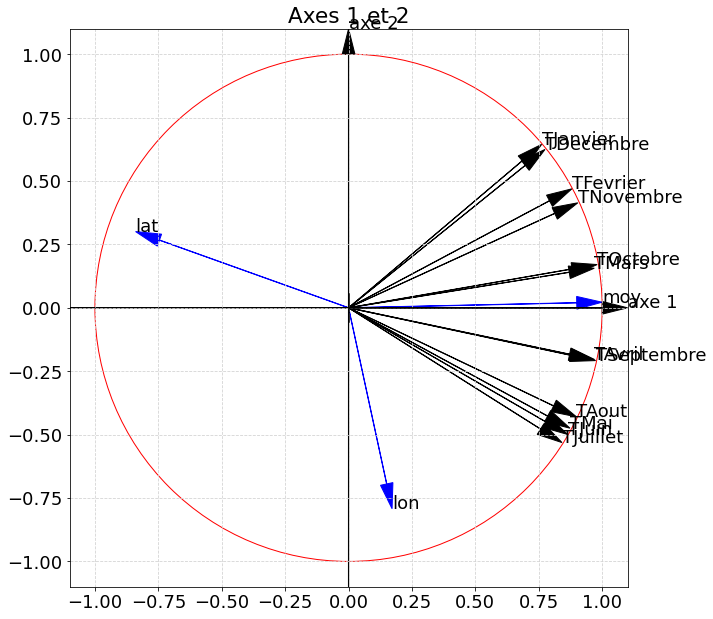

In [34]:
# coordonnees maximales de chacune des figures
x_lim = [-1.1,1.1]
y_lim = [-1.1,1.1]
cpt = 0
plt.subplots(figsize=(10,10*d))
for i in range(d-1):
    for j in range(i+1,d):
        cpt += 1
        ax = plt.subplot('{}{}{}'.format(int(d*(d-1)/2),1,cpt))
        # cercle unitaire
        cercle = plt.Circle((0,0),1,color='red',fill=False)
        ax.add_artist(cercle)
        #
        # projection du nuage des variables 
        for k in range(len(nomDesVariables)):
            ax.arrow(0, 0, coordonneesDesVariables.iloc[k,i], coordonneesDesVariables.iloc[k,j],length_includes_head=True, head_width=0.05, head_length=0.1, fc='k', ec='k')
            # Ornementation
            plt.text(coordonneesDesVariables.iloc[k,i], coordonneesDesVariables.iloc[k,j], nomDesVariables[k])#,fontsize=fontsize)
        if not coordonneesDesVariables_sup.shape[0] == 0:
            for k in range(len(nomDesVariables_sup)):
                ax.arrow(0, 0, coordonneesDesVariables_sup.iloc[k,i], coordonneesDesVariables_sup.iloc[k,j],length_includes_head=True, head_width=0.05, head_length=0.1, fc='b', ec='b')
                # Ornementation
                plt.text(coordonneesDesVariables_sup.iloc[k,i], coordonneesDesVariables_sup.iloc[k,j], nomDesVariables_sup[k])#,fontsize=fontsize)
        plt.title('Axes {} et {}'.format(i+1,j+1))
        #
        # ajout d'une grille
        plt.grid(color='lightgray',linestyle='--')
        # Ajouter des deux axes correspondants aux axes factoriels
        ax.arrow(x_lim[0], 0, x_lim[1]-x_lim[0], 0,length_includes_head=True, head_width=0.05, head_length=0.1, fc='k', ec='k')
        plt.plot(plt.xlim(), np.zeros(2),'k-')
        plt.text(x_lim[1], 0, "axe {:d}".format(i+1))
        #
        ax.arrow(0, y_lim[0], 0, y_lim[1]-y_lim[0],length_includes_head=True, head_width=0.05, head_length=0.1, fc='k', ec='k')
        plt.plot(np.zeros(2),plt.ylim(),'k-')
        plt.text(0,y_lim[1], "axe {:d}".format(j+1))
        #        ax.set_ylim([-1.1, 1.1])
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_aspect('equal')
        

### Représentation du nuage des individus (nouvelles coordonnées) :

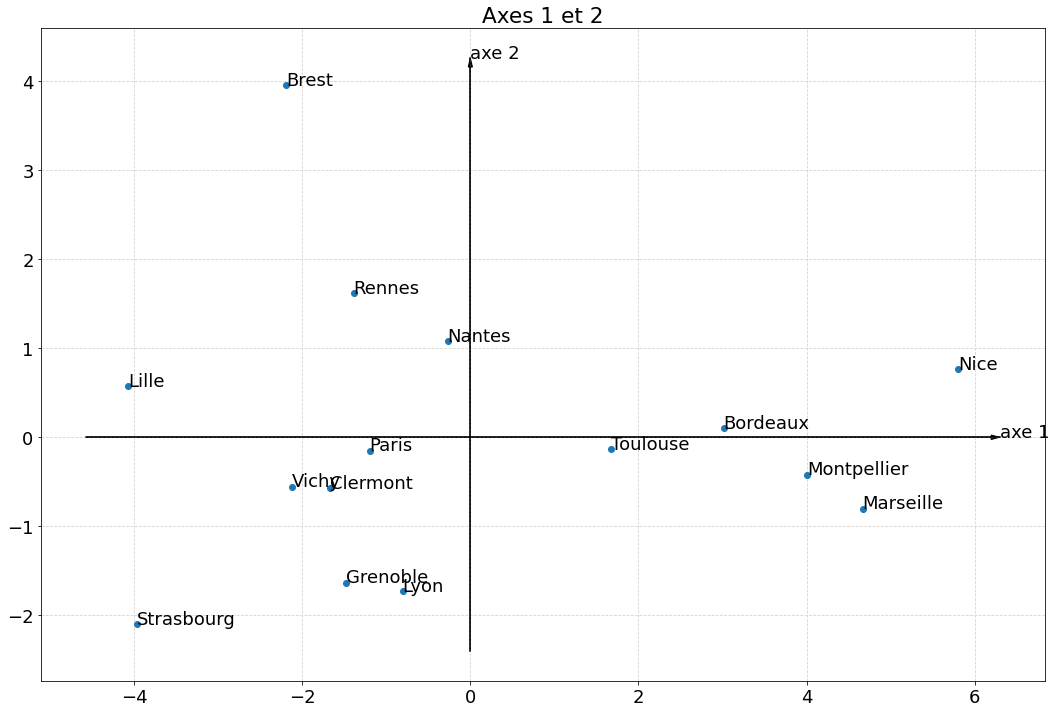

In [35]:
cpt = 0
plt.subplots(figsize=(18,6*d))
for i in range(d-1):
    for j in range(i+1,d):
        cpt += 1
        ax = plt.subplot('{}{}{}'.format(int(d*(d-1)/2),1,cpt))
        plt.plot(lesNouvellesCoordonnees[:,i],lesNouvellesCoordonnees[:,j],'o')
        plt.title('Axes {} et {}'.format(i+1,j+1))
        if len(nomDesIndividus) != 0 :
            for k in  range(len(nomDesIndividus)):
                plt.text(lesNouvellesCoordonnees[k,i], lesNouvellesCoordonnees[k,j], nomDesIndividus[k])#,fontsize=fontsize)
        # Ajouter les axes
        plt.grid(color='lightgray',linestyle='--')
        x_lim = plt.xlim()
        ax.arrow(x_lim[0], 0, x_lim[1]-x_lim[0], 0,length_includes_head=True, head_width=0.05, head_length=0.1, fc='k', ec='k')
        plt.plot(plt.xlim(), np.zeros(2),'k-')
        plt.text(x_lim[1], 0, "axe {:d}".format(i+1))
        y_lim = plt.ylim()
        ax.arrow(0,y_lim[0], 0, y_lim[1]-y_lim[0],length_includes_head=True, head_width=0.05, head_length=0.1, fc='k', ec='k')
        plt.plot(np.zeros(2),plt.ylim(),'k-')
        plt.text(0,y_lim[1], "axe {:d}".format(j+1))


### Reconstruction des données à partir d'une partie des composantes :

#### Les données reconstruites

In [36]:
# on reprend l'acp en limitant le nombre de facteurs
acp_ = PCA(n_components=d)
acp_.fit(Xcr)
# on determine le Xcr reconsrtuit a partir d'un nombre reduit de composantes de l'acp
Xcr_ = acp_.fit_transform(Xcr).dot(acp_.components_)+acp_.mean_
# et on en deduit le X reconstruit
X_ = Xcr_*ecartTypes+moyennes
X_= pd.DataFrame(data=X_, index=nomDesIndividus, columns=nomDesVariables)
#help(acp.fit_transform)
X_.columns = ['~' + str(col) for col in X_.columns]
X_

,~TJanvier,~TFevrier,~TMars,~TAvril,~TMai,~TJuin,~TJuillet,~TAout,~TSeptembre,~TOctobre,~TNovembre,~TDecembre
Bordeaux,5.55211,6.49691,9.69281,12.29558,15.66233,19.27918,21.49911,21.26706,18.71302,14.08883,9.56664,6.40926
Brest,6.28166,5.96601,7.81002,9.25396,11.63178,14.38969,15.59988,16.01965,14.70444,11.86793,8.72966,6.97779
Clermont,2.65952,3.61467,7.34488,10.35058,13.99697,17.33882,19.29752,18.92096,16.16292,11.23545,6.76529,3.56590
Grenoble,1.84613,3.10092,7.26849,10.63689,14.57855,18.06206,20.20104,19.63869,16.54318,11.12676,6.34167,2.80141
Lille,2.45525,3.00234,6.37471,9.06526,12.43291,15.45364,17.04431,16.85755,14.47100,10.07826,6.06582,3.31681
Lyon,2.09420,3.40112,7.57417,10.95258,14.90897,18.45519,20.66191,20.08601,16.95795,11.49542,6.64697,3.05152
Marseille,5.59167,6.84945,10.34102,13.20146,16.79301,20.64470,23.13597,22.75271,19.90588,14.85986,9.98919,6.48514
Montpellier,5.59064,6.71834,10.08424,12.83548,16.33216,20.08775,22.46769,22.14802,19.42391,14.55475,9.82856,6.46876
Nantes,4.76223,5.31439,8.27353,10.65395,13.80831,17.05821,18.86863,18.79060,16.55416,12.38515,8.31639,5.58610
Nice,7.49177,8.36044,11.13110,13.40553,16.53426,20.28445,22.62039,22.51909,20.16715,15.84045,11.36022,8.30773


#### valeurs originales (pour comparaison) :

In [37]:
df.iloc[indice_individus,indice_variables]

,TJanvier,TFevrier,TMars,TAvril,TMai,TJuin,TJuillet,TAout,TSeptembre,TOctobre,TNovembre,TDecembre
Bordeaux,5.6,6.6,10.3,12.8,15.8,19.3,20.9,21.0,18.6,13.8,9.1,6.2
Brest,6.1,5.8,7.8,9.2,11.6,14.4,15.6,16.0,14.7,12.0,9.0,7.0
Clermont,2.6,3.7,7.5,10.3,13.8,17.3,19.4,19.1,16.2,11.2,6.6,3.6
Grenoble,1.5,3.2,7.7,10.6,14.5,17.8,20.1,19.5,16.7,11.4,6.5,2.3
Lille,2.4,2.9,6.0,8.9,12.4,15.3,17.1,17.1,14.7,10.4,6.1,3.5
Lyon,2.1,3.3,7.7,10.9,14.9,18.5,20.7,20.1,16.9,11.4,6.7,3.1
Marseille,5.5,6.6,10.0,13.0,16.8,20.8,23.3,22.8,19.9,15.0,10.2,6.9
Montpellier,5.6,6.7,9.9,12.8,16.2,20.1,22.7,22.3,19.3,14.6,10.0,6.5
Nantes,5.0,5.3,8.4,10.8,13.9,17.2,18.8,18.6,16.4,12.2,8.2,5.5
Nice,7.5,8.5,10.8,13.3,16.7,20.1,22.7,22.5,20.3,16.0,11.5,8.2


#### La différence 

In [38]:
X_.columns = [col[1:] for col in X_.columns] ## on modifie l'intitule pour que les deux colonnes aient bien le meme intitule
erreurDeTroncature = df.iloc[indice_individus,indice_variables]-X_ ## erreur de reconstruction
X_.columns = ['~' + str(col) for col in X_.columns] ## on remet l'intitule originale
erreurDeTroncature

,TJanvier,TFevrier,TMars,TAvril,TMai,TJuin,TJuillet,TAout,TSeptembre,TOctobre,TNovembre,TDecembre
Bordeaux,0.04789,0.10309,0.60719,0.50442,0.13767,0.02082,-0.59911,-0.26706,-0.11302,-0.28883,-0.46664,-0.20926
Brest,-0.18166,-0.16601,-0.01002,-0.05396,-0.03178,0.01031,0.00012,-0.01965,-0.00444,0.13207,0.27034,0.02221
Clermont,-0.05952,0.08533,0.15512,-0.05058,-0.19697,-0.03882,0.10248,0.17904,0.03708,-0.03545,-0.16529,0.03410
Grenoble,-0.34613,0.09908,0.43151,-0.03689,-0.07855,-0.26206,-0.10104,-0.13869,0.15682,0.27324,0.15833,-0.50141
Lille,-0.05525,-0.10234,-0.37471,-0.16526,-0.03291,-0.15364,0.05569,0.24245,0.22900,0.32174,0.03418,0.18319
Lyon,0.00580,-0.10112,0.12583,-0.05258,-0.00897,0.04481,0.03809,0.01399,-0.05795,-0.09542,0.05303,0.04848
Marseille,-0.09167,-0.24945,-0.34102,-0.20146,0.00699,0.15530,0.16403,0.04729,-0.00588,0.14014,0.21081,0.41486
Montpellier,0.00936,-0.01834,-0.18424,-0.03548,-0.13216,0.01225,0.23231,0.15198,-0.12391,0.04525,0.17144,0.03124
Nantes,0.23777,-0.01439,0.12647,0.14605,0.09169,0.14179,-0.06863,-0.19060,-0.15416,-0.18515,-0.11639,-0.08610
Nice,0.00823,0.13956,-0.33110,-0.10553,0.16574,-0.18445,0.07961,-0.01909,0.13285,0.15955,0.13978,-0.10773


In [39]:
pd.set_option('precision', 2)
erreurDeTroncature.describe()

,TJanvier,TFevrier,TMars,TAvril,TMai,TJuin,TJuillet,TAout,TSeptembre,TOctobre,TNovembre,TDecembre
count,1.50e+01,1.50e+01,1.50e+01,1.50e+01,1.50e+01,1.50e+01,1.50e+01,1.50e+01,1.50e+01,15.00,15.00,1.50e+01
mean,-5.18e-17,-1.48e-16,-5.92e-17,-1.18e-16,1.18e-16,-5.92e-16,-3.55e-16,-4.74e-16,1.18e-16,0.00,0.00,1.48e-17
std,1.47e-01,1.29e-01,2.95e-01,1.95e-01,1.71e-01,1.25e-01,2.07e-01,1.76e-01,1.65e-01,0.19,0.20,2.02e-01
min,-3.46e-01,-2.49e-01,-4.03e-01,-2.44e-01,-3.07e-01,-2.62e-01,-5.99e-01,-2.67e-01,-3.27e-01,-0.29,-0.47,-5.01e-01
25%,-5.74e-02,-7.47e-02,-2.58e-01,-1.27e-01,-1.05e-01,-4.47e-02,-8.48e-02,-1.46e-01,-1.14e-01,-0.14,-0.13,-8.01e-02
50%,8.23e-03,-7.95e-03,-1.00e-02,-5.06e-02,-8.97e-03,1.22e-02,3.81e-02,-1.91e-02,-5.88e-03,0.03,0.05,3.12e-02
75%,8.83e-02,9.22e-02,1.41e-01,9.51e-02,1.15e-01,7.52e-02,9.21e-02,1.54e-01,1.21e-01,0.14,0.15,7.28e-02
max,2.38e-01,2.67e-01,6.07e-01,5.04e-01,3.04e-01,1.77e-01,2.81e-01,2.78e-01,3.04e-01,0.32,0.27,4.15e-01


***
**On est jamais mieux servi que par soi-même.**  
**If you want something done right, do it yourself.**

[pandas](https://pandas.pydata.org/) - [Numpy and Scipy](https://docs.scipy.org/doc/) - [matplotlib](https://matplotlib.org/) - [scikit-learn](http://scikit-learn.org/stable/) - [seaborn](https://seaborn.pydata.org/)